As per the Mr. Umair Shahzad this assignment is to learn that how the images can be converted to tensors and the accuracy is not that important. If Convolution, Image Augumentation and Transfer learning is used, then accuracy can be achived above 80%. But without all this stuff, accuracy is not good. So please don't reject this assignment. It took me 3 weeks to complete this assignment since initially I lost so much time to attain 85% accuracy by using convolution and Transfer learning. Thanks 

In [2]:
import os
import zipfile
import numpy as np
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.preprocessing import image
import tensorflow as tf
from google.colab import files
from keras import models
from keras import layers
from keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
local_zip = "/content/drive/MyDrive/flowers_new.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/flower_new")
zip_ref.close()

**Converting the images to gray scale tensor and resize**

In [70]:
def convert_image(source, label):
  fname = os.listdir(source)
  images= None
  
  for i,value in enumerate(fname):
    source_path = os.path.join(source, fname[i])
    if os.path.getsize(source_path)==0:
      print("file has zero size")
    else:
      img=image.load_img(source_path, target_size=(28, 28)) # Load image
      x=image.img_to_array(img)                               # Image to array RGB
      x=tf.image.rgb_to_grayscale(x)                          # gray scale conversion
      x=np.expand_dims(x, axis=0)
      if images is None:
        images = x
      else:
        images = np.vstack((images, x))
  print(images.shape)
  images=images.reshape(images.shape[0], 28*28*1)
  print(images.shape)
  label_in = np.ones((len(fname), 1))
  label_in.fill(label)
  print(label_in.shape)
  images_new=np.hstack((images,label_in))
  print(images_new.shape)
  return images_new


In [71]:
daisy_source_dir = "/flower_new/flowers/daisy"

dandelion_source_dir = "/flower_new/flowers/dandelion"

rose_source_dir = "/flower_new/flowers/rose"

sunflower_source_dir = "/flower_new/flowers/sunflower"

tulip_source_dir = "/flower_new/flowers/tulip"

**Converting the Images into tensor**

In [72]:
daisy = convert_image(daisy_source_dir, 0)
dandelion = convert_image(dandelion_source_dir, 1)
rose = convert_image(rose_source_dir, 2)
sunflower = convert_image(sunflower_source_dir, 3)
tulip = convert_image(tulip_source_dir, 4)

(769, 28, 28, 1)
(769, 784)
(769, 1)
(769, 785)
(1052, 28, 28, 1)
(1052, 784)
(1052, 1)
(1052, 785)
(784, 28, 28, 1)
(784, 784)
(784, 1)
(784, 785)
(734, 28, 28, 1)
(734, 784)
(734, 1)
(734, 785)
(984, 28, 28, 1)
(984, 784)
(984, 1)
(984, 785)


In [73]:
data_array = np.vstack((daisy, dandelion, rose, sunflower, tulip))
data_array.shape

(4323, 785)

In [74]:
np.random.shuffle(data_array)
data_array[:10,-1]

array([4., 3., 1., 1., 3., 1., 2., 4., 0., 1.])

**Splittig the Training and Testing Data**

In [75]:
train_data, test_data, train_labels, test_labels=train_test_split(data_array[0:,:-1], data_array[:,-1], test_size=0.4, random_state=1)

In [76]:
train_data.shape

(2593, 784)

In [77]:
test_data.shape

(1730, 784)

In [78]:
train_labels.shape

(2593,)

In [79]:
test_labels.shape

(1730,)

**One Hot encoding**

In [80]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [81]:
np.unique(test_labels)

array([0., 1.], dtype=float32)

**Normalizing the Data**

In [82]:
train_data=train_data.astype("float32")/255
test_data = test_data.astype("float32")/255

**Building the Network**

In [83]:
def build_model():
  model=models.Sequential()
  model.add(layers.Dense(100,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), input_shape=(784,)))
  model.add(layers.Dense(80,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation = "relu" ))
  model.add(layers.Dropout(.2))
  model.add(layers.Dense(80,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation = "relu" ))
  model.add(layers.Dropout(.2))
  model.add(layers.Dense(50,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation = "relu" ))
  model.add(layers.Dropout(.2))
  model.add(layers.Dense(40,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation = "relu" ))
  model.add(layers.Dense(5, activation="softmax"))
  model.compile(optimizer="rmsprop", loss = "categorical_crossentropy", metrics=["accuracy"])

  return model

**K fold Validation**

In [84]:
k= 4
num_val_sample = len(train_data) // k
num_epochs =100
all_scores = []
all_val_loss_histories = []
all_val_acc_histories = []
all_loss_histories =[]
all_acc_histories = []

for i in range(k):
  print("processing fold #",i)
  val_data = train_data[i*num_val_sample:(i+1)*num_val_sample]
  val_labels = train_labels[i*num_val_sample: (i+1)*num_val_sample]

  partial_train_data=np.concatenate([train_data[:i*num_val_sample], train_data[(i+1)*num_val_sample:]], axis=0)
  partial_train_labels=np.concatenate([train_labels[:i*num_val_sample], train_labels[(i+1)*num_val_sample:]], axis=0)

  model=build_model()
  history = model.fit(partial_train_data, partial_train_labels, validation_data = (val_data, val_labels), epochs= num_epochs, batch_size=512, verbose=1)
  val_loss, val_acc = model.evaluate(test_data, test_labels, verbose=0)
  val_loss_history = history.history["val_loss"]
  val_acc_history = history.history["val_accuracy"]
  loss_history = history.history["loss"]
  acc_history = history.history["accuracy"]
  all_loss_histories.append(loss_history)
  all_acc_histories.append(acc_history)
  all_val_loss_histories.append(val_loss_history)
  all_val_acc_histories.append(val_acc_history)
  all_scores.append(val_loss)
ave_val_loss_hist = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
ave_loss_hist = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
ave_val_acc_hist = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
ave_acc_hist = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
all_scores


processing fold # 0
Epoch 1/100
4/4 [==============================] - 1s 102ms/step - loss: 7.2190 - accuracy: 0.2030 - val_loss: 6.7213 - val_accuracy: 0.2546
Epoch 2/100
4/4 [==============================] - 0s 25ms/step - loss: 6.6420 - accuracy: 0.2052 - val_loss: 6.3057 - val_accuracy: 0.2330
Epoch 3/100
4/4 [==============================] - 0s 24ms/step - loss: 6.2315 - accuracy: 0.2406 - val_loss: 5.9488 - val_accuracy: 0.2423
Epoch 4/100
4/4 [==============================] - 0s 26ms/step - loss: 5.8707 - accuracy: 0.2506 - val_loss: 5.6102 - val_accuracy: 0.2840
Epoch 5/100
4/4 [==============================] - 0s 26ms/step - loss: 5.5639 - accuracy: 0.2543 - val_loss: 5.3546 - val_accuracy: 0.2022
Epoch 6/100
4/4 [==============================] - 0s 28ms/step - loss: 5.2898 - accuracy: 0.2525 - val_loss: 5.0591 - val_accuracy: 0.2778
Epoch 7/100
4/4 [==============================] - 0s 29ms/step - loss: 5.0238 - accuracy: 0.2675 - val_loss: 4.8295 - val_accuracy: 0.2793

[1.6893740892410278,
 1.6657776832580566,
 1.6719077825546265,
 1.6617282629013062]

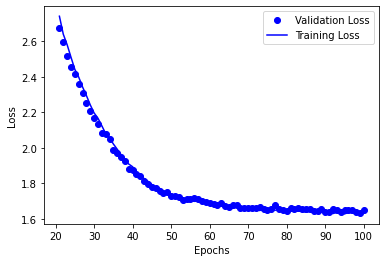

In [85]:
plt.plot(range(1, len(ave_val_loss_hist)+1)[20:], ave_val_loss_hist[20:], "bo", label="Validation Loss")
plt.plot(range(1, len(ave_val_loss_hist)+1)[20:], ave_loss_hist[20:], "b", label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

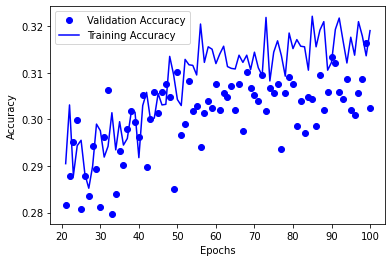

In [86]:
plt.plot(range(1, len(ave_val_acc_hist)+1)[20:], ave_val_acc_hist[20:], "bo", label="Validation Accuracy")
plt.plot(range(1, len(ave_val_acc_hist)+1)[20:], ave_acc_hist[20:], "b", label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Best Fit Model**

In [89]:
model=models.Sequential()
model.add(layers.Dense(100,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), input_shape=(784,)))
model.add(layers.Dense(80,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation = "relu" ))
model.add(layers.Dropout(.2))
model.add(layers.Dense(80,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation = "relu" ))
model.add(layers.Dropout(.2))
model.add(layers.Dense(50,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation = "relu" ))
model.add(layers.Dropout(.2))
model.add(layers.Dense(40,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation = "relu" ))
model.add(layers.Dense(5, activation="softmax"))
model.compile(optimizer="rmsprop", loss = "categorical_crossentropy", metrics=["accuracy"])

**Training the model with all samples**

In [90]:
model.fit(train_data,train_labels, epochs =100, batch_size=512, verbose=1)

Epoch 1/100
6/6 [==============================] - 1s 9ms/step - loss: 7.0715 - accuracy: 0.2091
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 6.2908 - accuracy: 0.2331
Epoch 3/100
6/6 [==============================] - 0s 12ms/step - loss: 5.7708 - accuracy: 0.2734
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 5.4282 - accuracy: 0.2373
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 5.0414 - accuracy: 0.2740
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 4.7080 - accuracy: 0.2867
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 4.3980 - accuracy: 0.2902
Epoch 8/100
6/6 [==============================] - 0s 9ms/step - loss: 4.1511 - accuracy: 0.2732
Epoch 9/100
6/6 [==============================] - 0s 9ms/step - loss: 3.8575 - accuracy: 0.2807
Epoch 10/100
6/6 [==============================] - 0s 12ms/step - loss: 3.5995 - accuracy: 0.3083
Epoch 11/100
6/6 [=======

**Evaluating the Model**

In [91]:
test_loss_score, test_acc_score=model.evaluate(test_data, test_labels)

55/55 [==============================] - 0s 1ms/step - loss: 1.6917 - accuracy: 0.2676


**Predicting the values**

In [92]:
prediction=model.predict(test_data)

In [93]:
prediction_result = []
for i, v in enumerate(prediction):
  prediction_result.append(np.argmax(prediction[i]))
print(prediction_result[15:25])

test_labels_result = []
for i, v in enumerate(test_labels):
  test_labels_result.append(np.argmax(test_labels[i]))
print(test_labels_result[15:25])

[1, 3, 4, 4, 3, 3, 4, 4, 1, 3]
[2, 4, 0, 4, 2, 3, 0, 1, 0, 2]


In [94]:
matched = []
for i, v in enumerate(test_labels_result):
  if  prediction_result[i] == test_labels_result[i]:
    matched.append("Yes")
  else:
    matched.append("No")

print("There are",matched.count("Yes"), "matched flowers and there are", matched.count("No"), "unmatched flowers ")

There are 463 matched flowers and there are 1267 unmatched flowers 
